# Direct Multistep Ensemble, Multivarite

We are training a seperate model for each timestep in the lookahead window, with multiple variables, on the first month of data.
Using hyperparameters from Mars et al


In [17]:
import pandas as pd
import numpy as np
from numpy import array
from numpy import mean
from numpy import std
from tensorflow import keras
from keras import optimizers
from keras.models import Sequential
from tensorflow.keras.layers import LSTM
from keras.layers import Dense
import matplotlib.pyplot as plt
from keras.layers import TimeDistributed
from sklearn.preprocessing import MinMaxScaler

In [18]:
def split_sequence(sequence, n_steps_in, n_steps_out, step_interval, n_step_lookahead):
    X, y = list(), list()
    example_count = int((len(sequence)/step_interval))
    for i in range(example_count):
        # find the end of this pattern
        end_ix = (i*step_interval) + n_steps_in
        out_start_ix = end_ix + n_step_lookahead -1
        out_end_ix = end_ix + n_steps_out + n_step_lookahead -1
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[(i*step_interval):end_ix], sequence[out_start_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [19]:
#To demonstrate above function
sequence = range(0,13)
n_steps_in = 1
n_steps_in = 5
n_steps_out =1
step_interval =1
n_step_lookahead=5
split_sequence(sequence, n_steps_in, n_steps_out, step_interval, n_step_lookahead)

(array([[0, 1, 2, 3, 4],
        [1, 2, 3, 4, 5],
        [2, 3, 4, 5, 6],
        [3, 4, 5, 6, 7]]),
 array([[ 9],
        [10],
        [11],
        [12]]))

Load data, datetime to index, downsample with left edge label, convert wei to gwei

In [39]:
def generate_training_val_examples():
    #Load data as float, datetime to index
    data = pd.read_csv (r'C:\Users\conal\Desktop\MCM\Practicum\data\ETH,gas,usage merged 11-26 to 01-26.csv', header=0)
    data['datetime'] = pd.to_datetime(data['datetime'], format = '%Y-%m-%d %H:%M:%S')
    data = data.set_index('datetime')
    data = data.squeeze()
    data = data.astype('float')

    #Resample with left edge label i.e min 1-5 mean labelled as min1
    data = data.resample(resample_rate).mean()

    #Add 24hr lag for min gas price
    data['min_gas_price_24hr_lag'] = data['min_gas_price'].shift(288)
    data = data[288:]
    
     #Filter inputs, set outlier limit
    data =data[inputs]
    data_mean, data_std = mean(data["min_gas_price"]), std(data["min_gas_price"])
    cut_off = data_std * 2
    lower, upper = data_mean - cut_off, data_mean + cut_off
    for index,row in data.iterrows():
      if row["min_gas_price"] < lower:
        row["min_gas_price"]=lower
      elif row["min_gas_price"] > upper:
        row["min_gas_price"]=upper


    #Filter inputs
    data =data[inputs]
    scaler = MinMaxScaler()
    data[inputs] = scaler.fit_transform(data[inputs])
    

    #Creat input:output examples
    data = data[start_date:end_date].to_numpy()
    X, y = split_sequence(data, n_steps_in, n_steps_out, step_interval, n_step_lookahead)
    y = y[:, :, :1]
    X_train, X_val = np.split(X, [int(0.7 * len(X))])
    #we are only lookign to forecast the min gas price
    y_train, y_val = np.split(y, [int(0.7 * len(X))])

    
    #Reshape to 3D for LSTM
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], len(inputs)))
    y_train =y_train.reshape((y_train.shape[0], y_train.shape[1], 1))
    X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], len(inputs)))
    y_val = y_val.reshape((y_val.shape[0], y_val.shape[1], 1))
    y_train =y_train[ :, :, :1]
    y_val =y_val[ :, :, :1]
    
    return X_train, y_train, X_val, y_val, scaler



In [40]:
def generate_training_val_examples_no_limits():
    #Load data as float, datetime to index
    data = pd.read_csv (r'C:\Users\conal\Desktop\MCM\Practicum\data\ETH,gas,usage merged 11-26 to 01-26.csv', header=0)
    data['datetime'] = pd.to_datetime(data['datetime'], format = '%Y-%m-%d %H:%M:%S')
    data = data.set_index('datetime')
    data = data.squeeze()
    data = data.astype('float')

    #Resample with left edge label i.e min 1-5 mean labelled as min1
    data = data.resample(resample_rate).mean()

    #Add 24hr lag for min gas price
    data['min_gas_price_24hr_lag'] = data['min_gas_price'].shift(288)
    data = data[288:]


    #Filter inputs
    data =data[inputs]
    scaler = MinMaxScaler()
    data[inputs] = scaler.fit_transform(data[inputs])
    

    #Creat input:output examples
    data = data[start_date:end_date].to_numpy()
    X, y = split_sequence(data, n_steps_in, n_steps_out, step_interval, n_step_lookahead)
    y = y[:, :, :1]
    X_train, X_val = np.split(X, [int(0.7 * len(X))])
    #we are only lookign to forecast the min gas price
    y_train, y_val = np.split(y, [int(0.7 * len(X))])

    
    #Reshape to 3D for LSTM
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], len(inputs)))
    y_train =y_train.reshape((y_train.shape[0], y_train.shape[1], 1))
    X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], len(inputs)))
    y_val = y_val.reshape((y_val.shape[0], y_val.shape[1], 1))
    y_train =y_train[ :, :, :1]
    y_val =y_val[ :, :, :1]
    
    return X_train, y_train, X_val, y_val, scaler

In [6]:
#Create Training Examples for all lookaheads
resample_rate = '5T'
start_date='2021-11-26 00:00:00'
end_date='2021-12-26 23:55:00' 
inputs = ['min_gas_price', 'max_gas_price', 'min_gas_price_24hr_lag']
#No of timesteps behind to forecast on, no of timesteps to forecast ahead
n_steps_in = 2016
n_steps_out = 1
#How many timesteps between start of training examples
step_interval = 1
n_step_lookahead = 1

In [67]:
X_train, y_train, X_val, y_val, scaler = generate_training_val_examples()

In [68]:
X_train2, y_train2, X_val2, y_val2, scaler2 = generate_training_val_examples_no_limits()

In [69]:

for i in range(1,11):
    n_step_lookahead = i
    X_train, y_train, X_val, y_val, scaler = generate_training_val_examples()
    X_train2, y_train2, X_val2, y_val2, scaler2 = generate_training_val_examples()

    model = Sequential()
    model.add(LSTM(units =15,activation='tanh',input_shape=(n_steps_in, len(inputs)),dropout=0.01))
    model.add(Dense(n_steps_out))
    model.compile(optimizer='adam', loss='mse')

    model.fit(X_train, y_train, epochs=15, verbose=1, validation_data =(X_val,y_val2))
    model.save(('Direct_Multivariate_Ensemble, n_outputs=1, mars3/' + str(i) + '_step_lookahead_Direct_Multivariate'))

Epoch 1/15
145/145 [==============================] - 11s 57ms/step - loss: 0.0145 - val_loss: 0.0047
Epoch 2/15
145/145 [==============================] - 8s 53ms/step - loss: 0.0088 - val_loss: 0.0044
Epoch 3/15
145/145 [==============================] - 8s 53ms/step - loss: 0.0081 - val_loss: 0.0041
Epoch 4/15
145/145 [==============================] - 8s 52ms/step - loss: 0.0076 - val_loss: 0.0039
Epoch 5/15
145/145 [==============================] - 8s 53ms/step - loss: 0.0072 - val_loss: 0.0038
Epoch 6/15
145/145 [==============================] - 8s 52ms/step - loss: 0.0068 - val_loss: 0.0038
Epoch 7/15
145/145 [==============================] - 8s 53ms/step - loss: 0.0063 - val_loss: 0.0033
Epoch 8/15
145/145 [==============================] - 8s 52ms/step - loss: 0.0061 - val_loss: 0.0032
Epoch 9/15
145/145 [==============================] - 8s 52ms/step - loss: 0.0059 - val_loss: 0.0032
Epoch 10/15
145/145 [==============================] - 8s 52ms/step - loss: 0.0059 - val_l

INFO:tensorflow:Assets written to: Direct_Multivariate_Ensemble, n_outputs=1, mars3/1_step_lookahead_Direct_Multivariate\assets


INFO:tensorflow:Assets written to: Direct_Multivariate_Ensemble, n_outputs=1, mars3/1_step_lookahead_Direct_Multivariate\assets


Epoch 1/15
145/145 [==============================] - 11s 56ms/step - loss: 0.0158 - val_loss: 0.0060
Epoch 2/15
145/145 [==============================] - 8s 53ms/step - loss: 0.0112 - val_loss: 0.0056
Epoch 3/15
145/145 [==============================] - 8s 53ms/step - loss: 0.0108 - val_loss: 0.0054
Epoch 4/15
145/145 [==============================] - 8s 53ms/step - loss: 0.0107 - val_loss: 0.0053
Epoch 5/15
145/145 [==============================] - 8s 52ms/step - loss: 0.0104 - val_loss: 0.0053
Epoch 6/15
145/145 [==============================] - 8s 52ms/step - loss: 0.0102 - val_loss: 0.0052
Epoch 7/15
145/145 [==============================] - 8s 52ms/step - loss: 0.0102 - val_loss: 0.0054
Epoch 8/15
145/145 [==============================] - 8s 57ms/step - loss: 0.0100 - val_loss: 0.0051
Epoch 9/15
145/145 [==============================] - 8s 53ms/step - loss: 0.0100 - val_loss: 0.0052
Epoch 10/15
145/145 [==============================] - 8s 52ms/step - loss: 0.0099 - val_l

INFO:tensorflow:Assets written to: Direct_Multivariate_Ensemble, n_outputs=1, mars3/2_step_lookahead_Direct_Multivariate\assets


INFO:tensorflow:Assets written to: Direct_Multivariate_Ensemble, n_outputs=1, mars3/2_step_lookahead_Direct_Multivariate\assets


Epoch 1/15
145/145 [==============================] - 10s 56ms/step - loss: 0.0207 - val_loss: 0.0064
Epoch 2/15
145/145 [==============================] - 8s 55ms/step - loss: 0.0126 - val_loss: 0.0068
Epoch 3/15
145/145 [==============================] - 8s 53ms/step - loss: 0.0123 - val_loss: 0.0061
Epoch 4/15
145/145 [==============================] - 8s 52ms/step - loss: 0.0120 - val_loss: 0.0060
Epoch 5/15
145/145 [==============================] - 8s 52ms/step - loss: 0.0119 - val_loss: 0.0060
Epoch 6/15
145/145 [==============================] - 8s 53ms/step - loss: 0.0118 - val_loss: 0.0059
Epoch 7/15
145/145 [==============================] - 8s 52ms/step - loss: 0.0117 - val_loss: 0.0064
Epoch 8/15
145/145 [==============================] - 8s 52ms/step - loss: 0.0116 - val_loss: 0.0059
Epoch 9/15
145/145 [==============================] - 8s 52ms/step - loss: 0.0117 - val_loss: 0.0060
Epoch 10/15
145/145 [==============================] - 8s 53ms/step - loss: 0.0116 - val_l

INFO:tensorflow:Assets written to: Direct_Multivariate_Ensemble, n_outputs=1, mars3/3_step_lookahead_Direct_Multivariate\assets


INFO:tensorflow:Assets written to: Direct_Multivariate_Ensemble, n_outputs=1, mars3/3_step_lookahead_Direct_Multivariate\assets


Epoch 1/15
145/145 [==============================] - 11s 57ms/step - loss: 0.0225 - val_loss: 0.0068
Epoch 2/15
145/145 [==============================] - 8s 52ms/step - loss: 0.0132 - val_loss: 0.0065
Epoch 3/15
145/145 [==============================] - 8s 52ms/step - loss: 0.0131 - val_loss: 0.0064
Epoch 4/15
145/145 [==============================] - 8s 52ms/step - loss: 0.0128 - val_loss: 0.0065
Epoch 5/15
145/145 [==============================] - 8s 53ms/step - loss: 0.0128 - val_loss: 0.0064
Epoch 6/15
145/145 [==============================] - 8s 52ms/step - loss: 0.0128 - val_loss: 0.0063
Epoch 7/15
145/145 [==============================] - 8s 52ms/step - loss: 0.0127 - val_loss: 0.0066
Epoch 8/15
145/145 [==============================] - 8s 53ms/step - loss: 0.0127 - val_loss: 0.0064
Epoch 9/15
145/145 [==============================] - 8s 53ms/step - loss: 0.0126 - val_loss: 0.0064
Epoch 10/15
145/145 [==============================] - 8s 53ms/step - loss: 0.0126 - val_l

INFO:tensorflow:Assets written to: Direct_Multivariate_Ensemble, n_outputs=1, mars3/4_step_lookahead_Direct_Multivariate\assets


INFO:tensorflow:Assets written to: Direct_Multivariate_Ensemble, n_outputs=1, mars3/4_step_lookahead_Direct_Multivariate\assets


Epoch 1/15
145/145 [==============================] - 10s 56ms/step - loss: 0.0232 - val_loss: 0.0073
Epoch 2/15
145/145 [==============================] - 8s 53ms/step - loss: 0.0140 - val_loss: 0.0069
Epoch 3/15
145/145 [==============================] - 8s 53ms/step - loss: 0.0138 - val_loss: 0.0071
Epoch 4/15
145/145 [==============================] - 8s 52ms/step - loss: 0.0138 - val_loss: 0.0067
Epoch 5/15
145/145 [==============================] - 8s 52ms/step - loss: 0.0137 - val_loss: 0.0073
Epoch 6/15
145/145 [==============================] - 8s 52ms/step - loss: 0.0136 - val_loss: 0.0067
Epoch 7/15
145/145 [==============================] - 8s 52ms/step - loss: 0.0135 - val_loss: 0.0067
Epoch 8/15
145/145 [==============================] - 8s 53ms/step - loss: 0.0135 - val_loss: 0.0067
Epoch 9/15
145/145 [==============================] - 9s 62ms/step - loss: 0.0134 - val_loss: 0.0069
Epoch 10/15
145/145 [==============================] - 9s 59ms/step - loss: 0.0135 - val_l

INFO:tensorflow:Assets written to: Direct_Multivariate_Ensemble, n_outputs=1, mars3/5_step_lookahead_Direct_Multivariate\assets


INFO:tensorflow:Assets written to: Direct_Multivariate_Ensemble, n_outputs=1, mars3/5_step_lookahead_Direct_Multivariate\assets


Epoch 1/15
145/145 [==============================] - 10s 57ms/step - loss: 0.0150 - val_loss: 0.0070
Epoch 2/15
145/145 [==============================] - 8s 53ms/step - loss: 0.0142 - val_loss: 0.0069
Epoch 3/15
145/145 [==============================] - 8s 54ms/step - loss: 0.0140 - val_loss: 0.0076
Epoch 4/15
145/145 [==============================] - 8s 53ms/step - loss: 0.0142 - val_loss: 0.0069
Epoch 5/15
145/145 [==============================] - 8s 53ms/step - loss: 0.0139 - val_loss: 0.0068
Epoch 6/15
145/145 [==============================] - 8s 53ms/step - loss: 0.0140 - val_loss: 0.0074
Epoch 7/15
145/145 [==============================] - 8s 53ms/step - loss: 0.0139 - val_loss: 0.0071
Epoch 8/15
145/145 [==============================] - 8s 53ms/step - loss: 0.0139 - val_loss: 0.0068
Epoch 9/15
145/145 [==============================] - 8s 54ms/step - loss: 0.0139 - val_loss: 0.0070
Epoch 10/15
145/145 [==============================] - 8s 53ms/step - loss: 0.0139 - val_l

INFO:tensorflow:Assets written to: Direct_Multivariate_Ensemble, n_outputs=1, mars3/6_step_lookahead_Direct_Multivariate\assets


INFO:tensorflow:Assets written to: Direct_Multivariate_Ensemble, n_outputs=1, mars3/6_step_lookahead_Direct_Multivariate\assets


Epoch 1/15
145/145 [==============================] - 10s 57ms/step - loss: 0.0177 - val_loss: 0.0076
Epoch 2/15
145/145 [==============================] - 8s 55ms/step - loss: 0.0146 - val_loss: 0.0071
Epoch 3/15
145/145 [==============================] - 8s 54ms/step - loss: 0.0145 - val_loss: 0.0071
Epoch 4/15
145/145 [==============================] - 8s 53ms/step - loss: 0.0145 - val_loss: 0.0071
Epoch 5/15
145/145 [==============================] - 8s 53ms/step - loss: 0.0145 - val_loss: 0.0071
Epoch 6/15
145/145 [==============================] - 8s 53ms/step - loss: 0.0144 - val_loss: 0.0073
Epoch 7/15
145/145 [==============================] - 8s 54ms/step - loss: 0.0145 - val_loss: 0.0070
Epoch 8/15
145/145 [==============================] - 8s 53ms/step - loss: 0.0144 - val_loss: 0.0071
Epoch 9/15
145/145 [==============================] - 8s 53ms/step - loss: 0.0144 - val_loss: 0.0071
Epoch 10/15
145/145 [==============================] - 8s 54ms/step - loss: 0.0143 - val_l

INFO:tensorflow:Assets written to: Direct_Multivariate_Ensemble, n_outputs=1, mars3/7_step_lookahead_Direct_Multivariate\assets


INFO:tensorflow:Assets written to: Direct_Multivariate_Ensemble, n_outputs=1, mars3/7_step_lookahead_Direct_Multivariate\assets


Epoch 1/15
145/145 [==============================] - 11s 57ms/step - loss: 0.0200 - val_loss: 0.0082
Epoch 2/15
145/145 [==============================] - 8s 54ms/step - loss: 0.0151 - val_loss: 0.0076
Epoch 3/15
145/145 [==============================] - 8s 53ms/step - loss: 0.0150 - val_loss: 0.0074
Epoch 4/15
145/145 [==============================] - 8s 54ms/step - loss: 0.0149 - val_loss: 0.0075
Epoch 5/15
145/145 [==============================] - 8s 53ms/step - loss: 0.0150 - val_loss: 0.0076
Epoch 6/15
145/145 [==============================] - 8s 53ms/step - loss: 0.0149 - val_loss: 0.0075
Epoch 7/15
145/145 [==============================] - 8s 53ms/step - loss: 0.0148 - val_loss: 0.0071
Epoch 8/15
145/145 [==============================] - 8s 53ms/step - loss: 0.0148 - val_loss: 0.0071
Epoch 9/15
145/145 [==============================] - 8s 53ms/step - loss: 0.0147 - val_loss: 0.0072
Epoch 10/15
145/145 [==============================] - 8s 53ms/step - loss: 0.0147 - val_l

INFO:tensorflow:Assets written to: Direct_Multivariate_Ensemble, n_outputs=1, mars3/8_step_lookahead_Direct_Multivariate\assets


INFO:tensorflow:Assets written to: Direct_Multivariate_Ensemble, n_outputs=1, mars3/8_step_lookahead_Direct_Multivariate\assets


Epoch 1/15
145/145 [==============================] - 11s 57ms/step - loss: 0.0358 - val_loss: 0.0082
Epoch 2/15
145/145 [==============================] - 8s 53ms/step - loss: 0.0163 - val_loss: 0.0079
Epoch 3/15
145/145 [==============================] - 8s 55ms/step - loss: 0.0158 - val_loss: 0.0080
Epoch 4/15
145/145 [==============================] - 8s 53ms/step - loss: 0.0155 - val_loss: 0.0077
Epoch 5/15
145/145 [==============================] - 8s 53ms/step - loss: 0.0154 - val_loss: 0.0076
Epoch 6/15
145/145 [==============================] - 8s 53ms/step - loss: 0.0153 - val_loss: 0.0074
Epoch 7/15
145/145 [==============================] - 8s 53ms/step - loss: 0.0153 - val_loss: 0.0076
Epoch 8/15
145/145 [==============================] - 8s 53ms/step - loss: 0.0151 - val_loss: 0.0076
Epoch 9/15
145/145 [==============================] - 8s 54ms/step - loss: 0.0153 - val_loss: 0.0074
Epoch 10/15
145/145 [==============================] - 8s 53ms/step - loss: 0.0151 - val_l

INFO:tensorflow:Assets written to: Direct_Multivariate_Ensemble, n_outputs=1, mars3/9_step_lookahead_Direct_Multivariate\assets


INFO:tensorflow:Assets written to: Direct_Multivariate_Ensemble, n_outputs=1, mars3/9_step_lookahead_Direct_Multivariate\assets


Epoch 1/15
145/145 [==============================] - 11s 57ms/step - loss: 0.0208 - val_loss: 0.0084
Epoch 2/15
145/145 [==============================] - 8s 53ms/step - loss: 0.0163 - val_loss: 0.0078
Epoch 3/15
145/145 [==============================] - 8s 54ms/step - loss: 0.0159 - val_loss: 0.0079
Epoch 4/15
145/145 [==============================] - 8s 52ms/step - loss: 0.0157 - val_loss: 0.0081
Epoch 5/15
145/145 [==============================] - 8s 52ms/step - loss: 0.0155 - val_loss: 0.0075
Epoch 6/15
145/145 [==============================] - 8s 52ms/step - loss: 0.0156 - val_loss: 0.0075
Epoch 7/15
145/145 [==============================] - 8s 52ms/step - loss: 0.0154 - val_loss: 0.0075
Epoch 8/15
145/145 [==============================] - 8s 52ms/step - loss: 0.0154 - val_loss: 0.0075
Epoch 9/15
145/145 [==============================] - 8s 52ms/step - loss: 0.0155 - val_loss: 0.0074
Epoch 10/15
145/145 [==============================] - 8s 52ms/step - loss: 0.0154 - val_l

INFO:tensorflow:Assets written to: Direct_Multivariate_Ensemble, n_outputs=1, mars3/10_step_lookahead_Direct_Multivariate\assets


INFO:tensorflow:Assets written to: Direct_Multivariate_Ensemble, n_outputs=1, mars3/10_step_lookahead_Direct_Multivariate\assets


## Evaluate 1 step lookahead


In [9]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error





### Generate the same training/valididation data for the first model

In [44]:
#Create Training Examples for all lookaheads
resample_rate = '5T'
start_date='2021-11-26 00:00:00'
end_date='2021-12-26 23:55:00' 
inputs = ['min_gas_price', 'max_gas_price', 'min_gas_price_24hr_lag', 'Open']
#No of timesteps behind to forecast on, no of timesteps to forecast ahead
n_steps_in = 2016
n_steps_out = 1
#How many timesteps between start of training examples
step_interval = 1
n_step_lookahead = 1

X_train, y_train, X_val, y_val, scaler = generate_training_val_examples()
X_train2, y_train2, X_val2, y_val2, scaler2 = generate_training_val_examples_no_limits()

In [45]:
model = keras.models.load_model('Direct_Multivariate_Ensemble, n_outputs=1, mars3/1_step_lookahead_Direct_Multivariate')

In [46]:
yhat = model.predict(X_val, verbose=1)

63/63 [==============================] - 2s 23ms/step


RMSE 12.100575741231557
MAE 7.453798179630799
MAPE 0.10679386953553693
R^2 0.7492011483739264


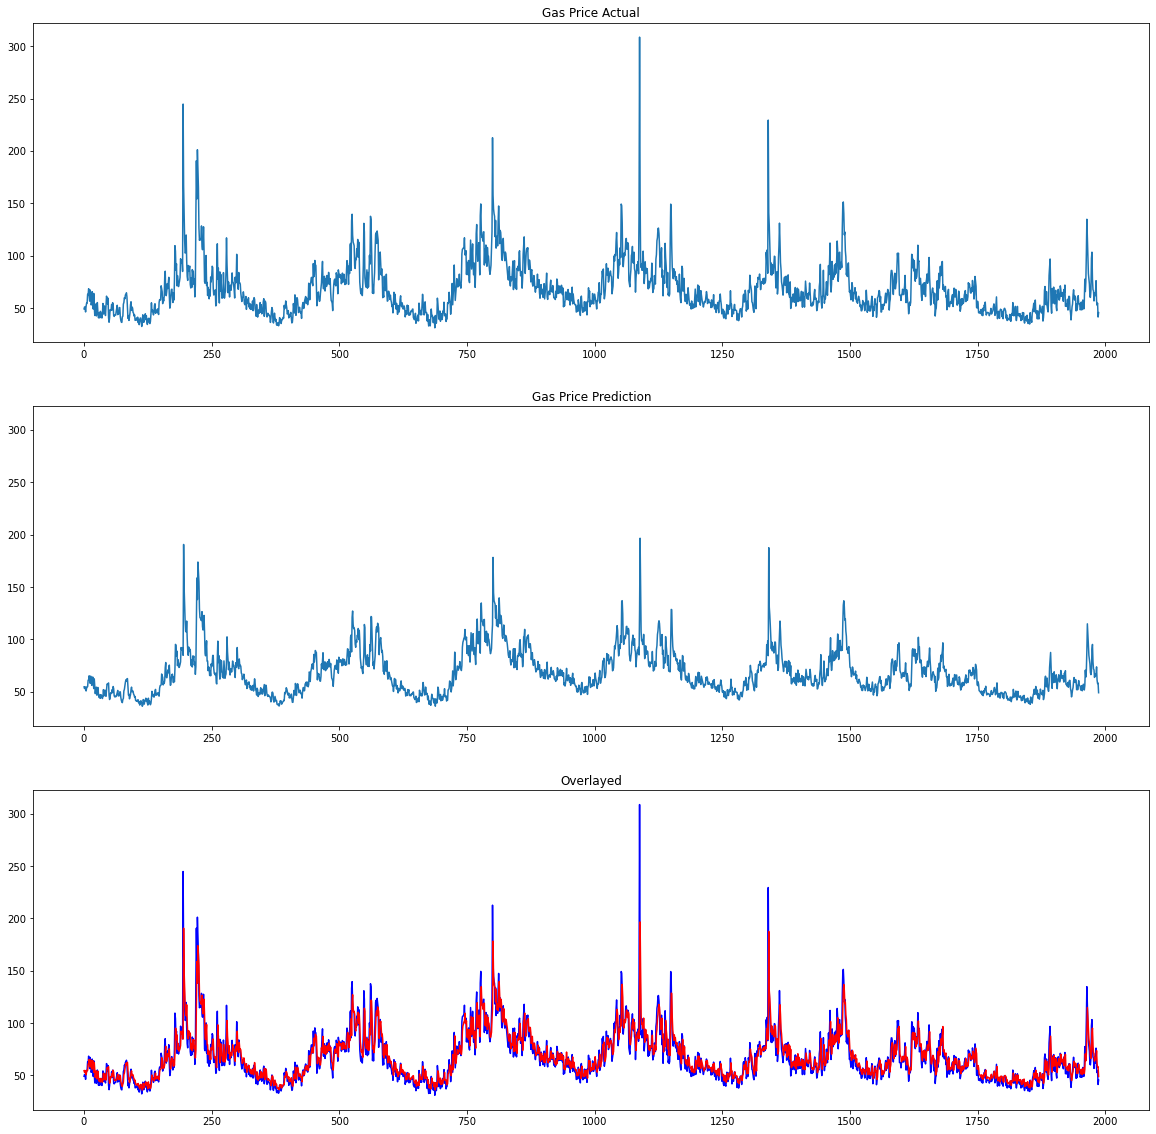

In [47]:
#Minmax scaler has been fit with nd data, add dummy columns so the scaler can be applied to min gas rpice
pred_descaled= (scaler.inverse_transform(array([yhat,]*(len(inputs))).transpose()[0]))[:, :1]
groud_truth_descaled= (scaler2.inverse_transform(array([y_val2,]*(len(inputs))).transpose()[0][0]))[ :, :1]


f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharey=True)
f.set_figwidth(20)
f.set_figheight(20)
ax1.plot(groud_truth_descaled)
ax1.title.set_text('Gas Price Actual')
ax2.plot(pred_descaled)
ax2.title.set_text('Gas Price Prediction')
ax3.title.set_text('Overlayed')
ax3.plot(groud_truth_descaled, color='blue',label='Predicted '+' Gas Price')
ax3.plot(pred_descaled, color='red',label='real '+' Gas Price')



print('RMSE ' + str(mean_squared_error(groud_truth_descaled, pred_descaled, squared=False)))
print('MAE ' + str(mean_absolute_error(groud_truth_descaled, pred_descaled)))
print('MAPE ' + str(mean_absolute_percentage_error(groud_truth_descaled, pred_descaled)))
print('R^2 ' + str(r2_score(groud_truth_descaled, pred_descaled)))

# Lets look at the 10 step lookahead

In [75]:
#Create Training Examples for all lookaheads
resample_rate = '5T'
start_date='2021-11-26 00:00:00'
end_date='2022-12-26 23:55:00' 
inputs = ['min_gas_price', 'max_gas_price', 'min_gas_price_24hr_lag']
#No of timesteps behind to forecast on, no of timesteps to forecast ahead
n_steps_in = 2016
n_steps_out = 1
#How many timesteps between start of training examples
step_interval = 1
n_step_lookahead = 10

X_train, y_train, X_val, y_val, scaler = generate_training_val_examples()
X_train2, y_train2, X_val2, y_val2, scaler2 = generate_training_val_examples_no_limits()

In [73]:
model = keras.models.load_model('Direct_Multivariate_Ensemble, n_outputs=1, mars3/10_step_lookahead_Direct_Multivariate')

In [76]:
yhat = model.predict(X_val, verbose=1)

146/146 [==============================] - 4s 22ms/step


RMSE 57.991784586508494
MAE 28.50120556823496
MAPE 0.15846235231471062
R^2 0.2076505858502654


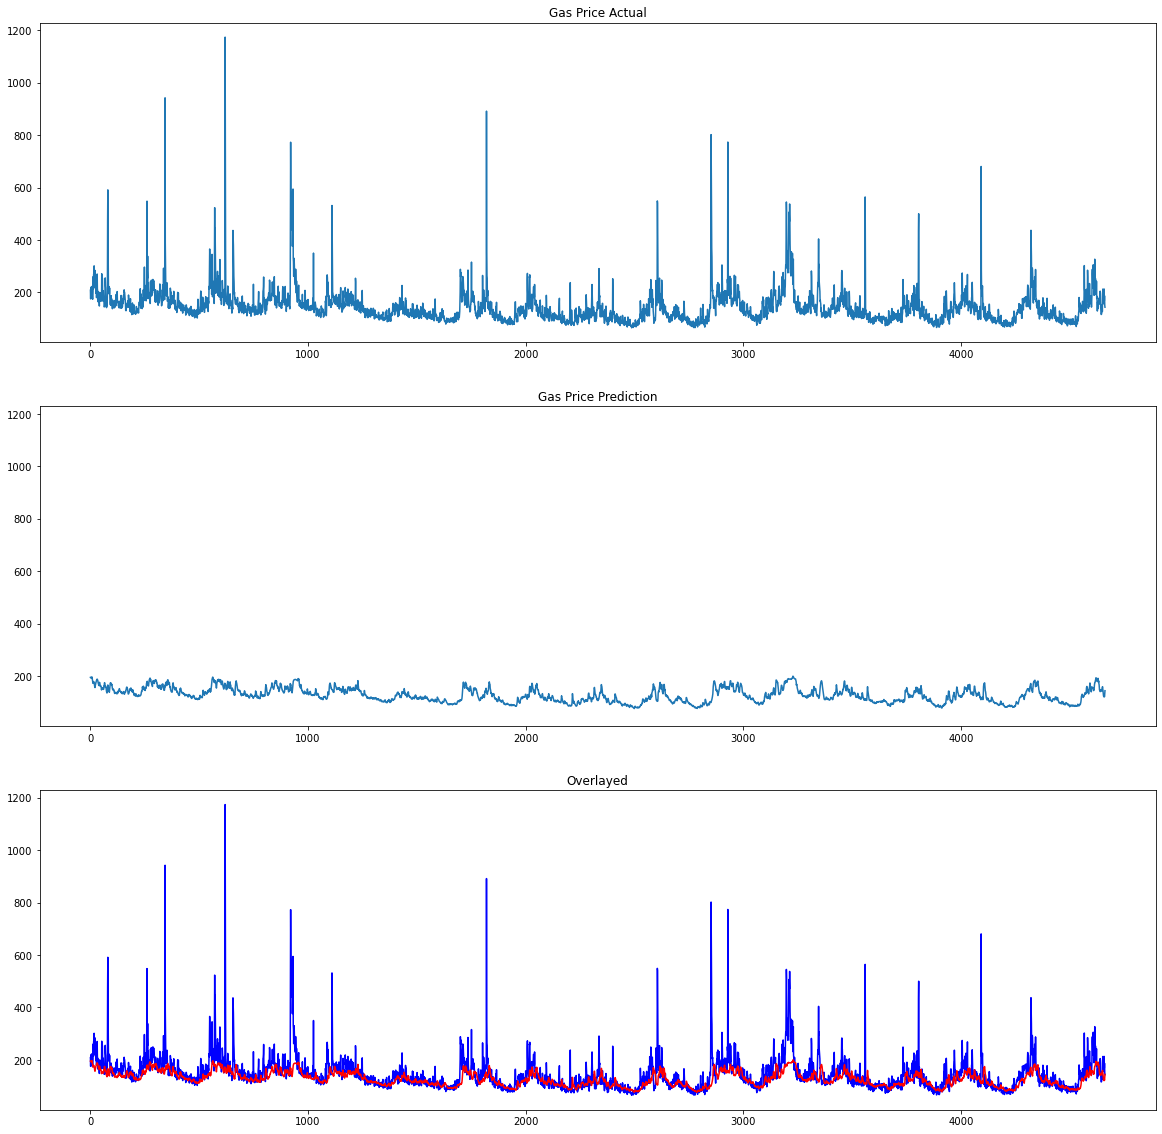

In [77]:
#Minmax scaler has been fit with nd data, add dummy columns so the scaler can be applied to min gas rpice
pred_descaled= (scaler.inverse_transform(array([yhat,]*(len(inputs))).transpose()[0]))[:, :1]
groud_truth_descaled= (scaler2.inverse_transform(array([y_val2,]*(len(inputs))).transpose()[0][0]))[ :, :1]
#groud_truth_descaled= (scaler.inverse_transform(array([y_val,]*(len(inputs))).transpose()[0][0]))[ :, :1]

f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharey=True)
f.set_figwidth(20)
f.set_figheight(20)
ax1.plot(groud_truth_descaled)
ax1.title.set_text('Gas Price Actual')
ax2.plot(pred_descaled)
ax2.title.set_text('Gas Price Prediction')
ax3.title.set_text('Overlayed')
ax3.plot(groud_truth_descaled, color='blue',label='Predicted '+' Gas Price')
ax3.plot(pred_descaled, color='red',label='real '+' Gas Price')



print('RMSE ' + str(mean_squared_error(groud_truth_descaled, pred_descaled, squared=False)))
print('MAE ' + str(mean_absolute_error(groud_truth_descaled, pred_descaled)))
print('MAPE ' + str(mean_absolute_percentage_error(groud_truth_descaled, pred_descaled)))
print('R^2 ' + str(r2_score(groud_truth_descaled, pred_descaled)))

## Lets look at the metrics for all lookaheads

In [7]:

def descale_y_retrun_metrics(yhat, y_val2):
    #We will use validation data that has not had outleirs limited, will be a different min/max scaler as such
    pred_descaled= (scaler.inverse_transform(array([yhat,]*(len(inputs))).transpose()[0]))[:, :1]
    groud_truth_descaled= (scaler2.inverse_transform(array([y_val2,]*(len(inputs))).transpose()[0][0]))[ :, :1]
    RMSE = mean_squared_error(groud_truth_descaled, pred_descaled, squared=False)
    MSE = mean_squared_error(groud_truth_descaled, pred_descaled, squared=True)
    MAE = mean_absolute_error(groud_truth_descaled, pred_descaled)
    MAPE = mean_absolute_percentage_error(groud_truth_descaled, pred_descaled)
    R2 = r2_score(groud_truth_descaled, pred_descaled)
    return RMSE, MAE, MAPE, R2, MSE

In [50]:
resample_rate = '5T'
start_date='2021-11-26 00:00:00'
end_date='2021-12-26 23:55:00' 
inputs = ['min_gas_price', 'max_gas_price', 'min_gas_price_24hr_lag']
#No of timesteps behind to forecast on, no of timesteps to forecast ahead
n_steps_in = 2016
n_steps_out = 1
#How many timesteps between start of training examples
step_interval = 1
n_step_lookahead = 1

RMSE_list, MAE_list, MAPE_list, R2_list, MSE_list = [],[],[],[],[]
for i in range(1,11):
    n_step_lookahead = i
    model = keras.models.load_model('Direct_Multivariate_Ensemble, n_outputs=1, mars3/1_step_lookahead_Direct_Multivariate')
    X_train, y_train, X_val, y_val, scaler = generate_training_val_examples()
    X_train2, y_train2, X_val2, y_val2, scaler2 = generate_training_val_examples_no_limits()
    yhat = model.predict(X_val, verbose=1)
    RMSE, MAE, MAPE, R2, MSE = descale_y_retrun_metrics(yhat, y_val2)
    RMSE_list.append(RMSE)
    MAE_list.append(MAE)
    MAPE_list.append(MAPE)
    R2_list.append(R2)
    MSE_list.append(MSE)

63/63 [==============================] - 2s 25ms/step


In [51]:
metrics_df = pd.DataFrame({'RMSE':RMSE_list, 'MSE':RMSE_list, 'MAE':MAE_list, 'MAPE':MAPE_list, 'R2':R2_list}, index=range(1,11))


In [53]:
metrics_df.to_csv('Direct_Multistep_Multivariate_Metrics_Mars3.csv')

In [52]:
metrics_df

,RMSE,MSE,MAE,MAPE,R2
1,12.330689,12.330689,7.970139,0.119356,0.739572
2,15.387040,15.387040,9.938724,0.145501,0.594555
3,17.000018,17.000018,11.042497,0.159378,0.505096
4,17.892234,17.892234,11.646344,0.167229,0.451785
5,18.600817,18.600817,12.199627,0.174528,0.407662
6,19.143037,19.143037,12.597652,0.179590,0.372625
7,19.534153,19.534153,12.808229,0.183020,0.346727
8,19.669078,19.669078,13.031159,0.186726,0.337671
9,19.734012,19.734012,13.149669,0.189090,0.333465
10,19.746660,19.746660,13.343107,0.192777,0.332610
